<a href="https://colab.research.google.com/github/bipinKrishnan/fastai_course/blob/master/fastai_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastai --upgrade

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision.datasets.utils import download_and_extract_archive
from torchvision.transforms import transforms
from torchvision.models import resnet18

import os
import re
from PIL import Image
from tqdm.notebook import tqdm

In [ ]:
url = 'https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz'
file_name = 'pet_breed3'

download_and_extract_archive(url, file_name)

In [ ]:
img_path = '/content/pet_breed3/images/'
!rm -r '/content/pet_breed3/images/.ipynb_checkpoints'

len(os.listdir(img_path)), os.listdir(img_path)[:3]

In [ ]:
pattern = '(.+)_[0-9]+.jpg$'

os.listdir(img_path)[15], re.findall(pattern, os.listdir(img_path)[15])[0]

Load data set

In [3]:
import pandas as pd

In [4]:
def build_label(img_path=img_path):
  name = [re.findall(pattern, x) for x in os.listdir(img_path)]

  return (pd.DataFrame(name)[0].unique()).tolist()

In [ ]:
len(build_label()), build_label()

In [8]:
class LoadDataset(Dataset):
  def __init__(self, path, label, transform, train=True):
    super().__init__()
    self.path = path
    self.label = label
    self.transform = transform

    if train:
      self.dataset = os.listdir(self.path)[:6000]
    else:
      self.dataset = os.listdir(self.path)[6000:]

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    img = Image.open(self.path+self.dataset[idx])

    if self.transform:
      return self.transform(img), self.label.index(re.findall('(.+)_[0-9]+.jpg$', self.dataset[idx])[0])

    else:
      return img, self.label.index(re.findall('(.+)_[0-9]+.jpg$', self.dataset[idx])[0])

In [9]:
train_transform = transforms.Compose([
                                      transforms.Resize((224, 224)),
                                      transforms.Grayscale(3),
                                      transforms.ToTensor()
])

val_transform = transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.Grayscale(3),
                                    transforms.ToTensor()
])

trainset = LoadDataset(img_path, build_label(), train_transform, train=True)
valset = LoadDataset(img_path, build_label(), train_transform, train=False)

In [10]:
trainloader = DataLoader(trainset, 4)
testloader = DataLoader(valset, 4)

In [ ]:
for i, j in trainset:
  print(len(trainset))
  print(i.shape, j)
  break

for k, l in valset:
  print(len(valset))
  print(k.shape, l)
  break

In [ ]:
for i in trainloader:
  print((i))
  break

## Fastai + PyTorch

In [13]:
import fastai 
import fastai.vision.all as vision

In [31]:
loader = vision.DataLoaders(trainloader, testloader)

In [32]:
learn = vision.Learner(
                        loader, 
                        resnet18(pretrained=True), 
                        loss_func=torch.nn.CrossEntropyLoss(), 
                        opt_func=vision.Adam, 
                        metrics=vision.accuracy, 
                        cbs=vision.CudaCallback
    )

SuggestedLRs(lr_min=0.0015848932787775993, lr_steep=0.002511886414140463)

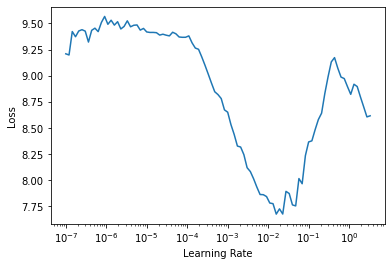

In [33]:
learn.freeze()
learn.lr_find()

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.002511886414140463)

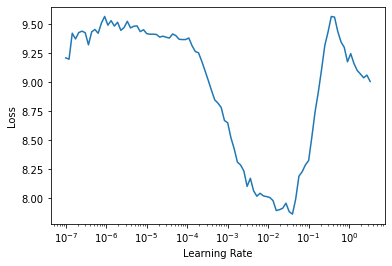

In [34]:
learn.unfreeze()
learn.lr_find()

In [23]:
learn.fine_tune(3, base_lr=1e-3, max_lr=slice(2e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,3.230972,3.489278,0.156115,01:22


epoch,train_loss,valid_loss,accuracy,time
0,1.765998,2.338350,0.426619,01:22
1,0.790299,1.441004,0.600000,01:23
2,0.194233,0.978354,0.721583,01:23


## PyTorch

In [18]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = resnet18(pretrained=True)

# for params in model.parameters():
#   params.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 37)

model = model.to(device)
opt = torch.optim.Adam(model.parameters(), 1e-3)
criterion = torch.nn.CrossEntropyLoss()

In [19]:
epochs = 4

for epoch in range(epochs):
  model.train()
  for data, label in tqdm(trainloader, total=len(trainloader)):
    data, label = data.to(device), label.to(device)
    opt.zero_grad()

    out = model(data)
    loss = criterion(out, label)

    loss.backward()
    opt.step()

  model.eval()
  for val_data, val_label in testloader:
    val_data, val_label = val_data.to(device), val_label.to(device)

    val_out = model(val_data)
    val_loss = criterion(val_out, val_label)

  print("Epoch: {}/{}\t train_loss: {:.6f}\t val_loss: {:.6f}".format(epoch+1, epochs, loss.item(), val_loss.item()))


Epoch: 1/4	 train_loss: 3.865203	 val_loss: 3.864577



Epoch: 2/4	 train_loss: 3.249729	 val_loss: 3.844471



Epoch: 3/4	 train_loss: 3.063180	 val_loss: 3.781823



Epoch: 4/4	 train_loss: 3.025064	 val_loss: 4.392303
